Terms   Binomial Expansion
    2 = 1.0 - 1.0*x**2
    3 = 1.0*x**4 - 1.0*x**2 + 1.0
    4 = -1.0*x**6 + 1.0*x**4 - 1.0*x**2 + 1.0
    5 = 1.0*x**8 - 1.0*x**6 + 1.0*x**4 - 1.0*x**2 + 1.0
    6 = -1.0*x**10 + 1.0*x**8 - 1.0*x**6 + 1.0*x**4 - 1.0*x**2 + 1.0
    7 = 1.0*x**12 - 1.0*x**10 + 1.0*x**8 - 1.0*x**6 + 1.0*x**4 - 1.0*x**2 + 1.0


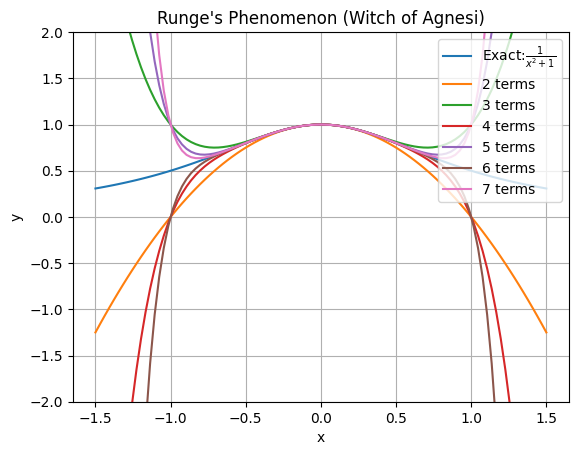

In [113]:
"""agnesi_witch.ipynb"""

# This code expresses Maria Agnesi's "witch" as a function 𝑓(𝑥) using the simplified equation where 𝑎=1⁄2,
# and then expresses 𝑓(𝑥) as a power series over −1<𝑥<1.

# Code is modified from that given by Dr. David Biersach in newton_binomial.py.

# Code is also aided by the following online resources:
# https://en.wikipedia.org/wiki/Binomial_theorem
# https://en.wikipedia.org/wiki/Witch_of_Agnesi#:~:text=The%20witch%20of%20Agnesi%20approximates,a%20flow%20in%20mathematical%20modeling.
# https://numpy.org/doc/stable/reference/routines.polynomials.chebyshev.html
# https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebval.html
# https://numpy.org/doc/stable/reference/generated/numpy.polynomial.chebyshev.chebfit.html

# Allows for annotations and type hinting
from __future__ import annotations

# Provides type hints and annotations
import typing

# Used for plotting functions
import matplotlib.pyplot as plt

# Used for calculations
import numpy as np

# Used to convert symbolic expressions into functions
from sympy import Float, Number, lambdify, symbols  # type: ignore


if typing.TYPE_CHECKING:
    # Import the type any from the typing module for our tuple later on
    from typing import Any

    # Import axes for plot features within an individual plot
    from matplotlib.axes import Axes

    # Used for vectorized operations
    from numpy.typing import NDArray

# Used later on to plot the polynomial interpolation with Chebyshev nodes
from scipy.special import roots_chebyt  # type: ignore

# According to the binomial theorem-> it is possible to expand any NON-NEGATIVE integer power of x+y into the form (where y=1):
# (1+x)**n= (n:0)(x**0)+ (n:1)(x**1)+ (n:2)(x**2)+...(n:n)(x**n)

# Simplified Agnesi's witch function with a=1/2-> y= (x**2+1)**-1
# area between the witch function and its asymptotic line -> 4pi(a**2)


def expr_to_str(expr: Any, num_digits: int) -> Any:
    """
    Returns a string representation of the given polynomial expression
    rounding each coefficient to fractional part with num_digits precision
    """
    # This function intakes an expression and a number of digits and will
    # return a string representation of the expression with each coefficient rounded to the number of digits.
    return expr.xreplace(
        {
            n.evalf(): n if type(n) == int else Float(n, num_digits)  # type: ignore
            for n in expr.atoms(Number)
        }
    )


def calc_coeff(a: int, b: int, r: float, n: int) -> float:
    """
    Returns the coefficient for the nth term in the Binomial expansion of (a+b)^r
    """
    coeff: float = 1.0
    for m in range(n):
        coeff = coeff * (r - m) / (m + 1)
    coeff = coeff * pow(a, r - n)
    coeff = coeff * pow(b, n)
    return coeff


def binomial_expand(a: int, b: int, c: int, r: float, max_t: int) -> tuple[Any, Any]:
    """
    Returns a tuple containing the Binomial Expansion of (a+b*x^c)^r
    to max_t terms as a Sympy Polynomial in x along with
    a callable Numpy expression for that expansion
    """
    x: Any = symbols("x")
    poly: float = 0.0
    for t in range(max_t):
        # Append this term (as a symbolic expression in x)
        # to the growing polynomial of max_t terms
        poly += calc_coeff(a, b, r, t) * x ** (c * t)
    # Returns a symbolic polynomial in x and a numpy expression for the expansion.
    return poly, lambdify(x, poly.as_expr(), modules="numpy")  # type: ignore


def plot(ax: Axes, x: NDArray[np.float_], cheby: bool) -> None:
    # plot Agnesi's simplified witch function
    ax.plot(x, 1 / (np.power(x, 2) + 1), label=f"Exact:" rf"$\frac{{1}}{{x^2+1}}$")
    # If we are not using Chebyshev nodes to plot the interpolation:
    if not cheby:
        # Calculate Newton's estimate/ power series -> (𝑎+𝑏𝑥^𝑐 )^𝑟
        # Print the binomial expansion
        print(f"{'Terms':>5}   Binomial Expansion")
        # For terms in the range 2 to 7
        for t in range(2, 8):
            # Use Newton's Binomial Theorem to expand Agnesi's witch to 't' terms
            # a=1, b=1, c=2, r=-1
            eqn: tuple[Any, Any] = binomial_expand(1, 1, 2, -1, t)
            # Evaluate the symbolic expression across the domain x=[-1,1]
            # if we needed to manually vectorize this function ourself
            # map is built into python-> given a function and an array of values,
            # one by one calls the function for each value of x
            # returns back a list of those values
            print(f"{t:>5} = {expr_to_str(eqn[0], 1)}")
            ax.plot(x, np.array(list(map(eqn[1], x))), label=f"{t} terms")
    # If we are using chebyshev nodes:
    if cheby == True:
        # Calculate Chebyshev nodes
        t: NDArray[np.float_] = np.cos(np.arange(0, 8) * np.pi / 7)
        # Calculate interpolation coefficients
        y_interp: NDArray[np.float_] = 1 / (np.power(t, 2) + 1)

        # Interpolate using Chebyshev polynomials
        p_interp = np.polynomial.chebyshev.chebfit(t, y_interp, 7)
        y_cheb = np.polynomial.chebyshev.chebval(x, p_interp)
        # Plot the Chebyshev polynomials
        ax.plot(x, y_cheb, label="Chebyshev Interpolation")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # Create grid lines
    ax.grid()
    ax.set_title(r"Runge's Phenomenon (Witch of Agnesi)")
    ax.legend(loc="upper right")
    ax.set_ylim(-2, 2)
    plt.show()


# x is between -1.5 to 1.5
# Define x as an array of float values
x: NDArray[np.float_] = np.linspace(-1.5, 1.5, 100, dtype=np.float_)
# cheby is initialized to false
cheby: bool = False
plot(plt.axes(), x, cheby)

Question 1. Consider expanding the domain to include ℂ such as 𝑥=−𝑖 or 𝑥=𝑖, what happens at those points?
-> Agnesi’s Witch Function experiences discontinuities at the points +/- i. This is because the denominator (x^2 +1) becomes 0 at those points. In the graph generated by cell 1, the polynomial interpolation values near the midpoints are quite accurate, but eventually oscillate towards the endpoints. These endpoints are the closest values to the function’s discontinuities at +/-i. Thus, these discontinuities could contribute to Runge’s Phenomenon. -> Answer was aided by: https://www.math.umd.edu/~mariakc/AMSC466/LectureNotes/interpolation.pdf.


/var/folders/6n/yv5wkr992fx2crc74vsxd8pm0000gp/T/ipykernel_45842/2384122580.py:8: RuntimeWarning: divide by zero encountered in divide
  return 1 / (np.power(x, 2) + 1)
/var/folders/6n/yv5wkr992fx2crc74vsxd8pm0000gp/T/ipykernel_45842/2384122580.py:8: RuntimeWarning: invalid value encountered in divide
  return 1 / (np.power(x, 2) + 1)
/usr/local/Caskroom/miniconda/base/envs/qis101/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


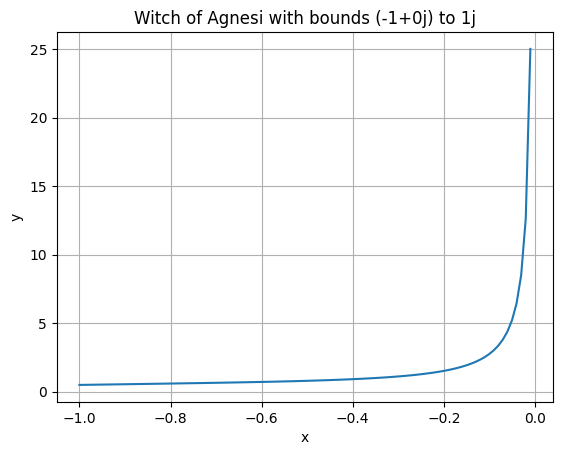

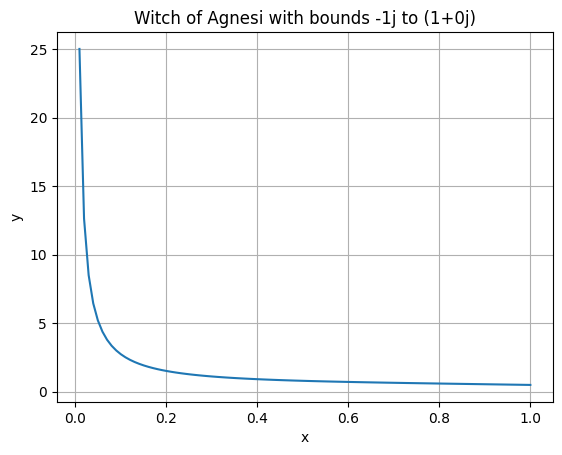

In [114]:
# Code explanation for Question 1:

# This code highlights how the Witch of Agnesi function has discontinuities at x=+/- i


def witch_of_agnesi(x: NDArray[np.complex128]) -> NDArray[np.complex128]:
    """Define Agnesi's Witch Function such that it can handle complex numbers"""
    return 1 / (np.power(x, 2) + 1)


def plot_agnesi_i(ax: Axes, x: NDArray[np.complex128]) -> None:
    # Calculate the corresponding y values using the Witch of Agnesi function based on our given x
    y: NDArray[np.complex128] = witch_of_agnesi(x)
    # Plot x and y
    ax.plot(x, y)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # Create grid lines
    ax.grid()
    ax.set_title(rf"Witch of Agnesi with bounds {x[0]} to {x[-1]}")
    plt.show()


# Define the range of x values, first from -1 to +i
x: NDArray[np.complex128] = np.linspace(-1, 1j, 100)

plot_agnesi_i(plt.axes(), x)

# Define the range of x values, first from -i to 1
x: NDArray[np.complex128] = np.linspace(-1j, 1, 100)
plot_agnesi_i(plt.axes(), x)

Question 2. Explain why Agnesi’s Witch oscillates wildly (as we add more terms to the power series) as we approach 𝑥=−1 or 𝑥=1:
-> The nodal points of an approximating power series are defined as the supposed intersections between the exact function and the approximating series. Based on the graph generated in cell #1, the nodal points become much worse approximations towards the endpoints as they fail to intersect with the exact function. This variation in nodal approximation can be attributed to the uniform spacing in between the nodes. The equal spacing issue arises out of the horizontal orientation with which the nodes are projected. If we were to instead project the approximated data points along a semi-circle and then project those points onto a horizontal plane, we would get a much better approximation. This is known as Chebyshev spacing.
-> Answer was aided by: https://www.youtube.com/watch?v=F_43oTnTXiw and https://en.wikipedia.org/wiki/Chebyshev_nodes.


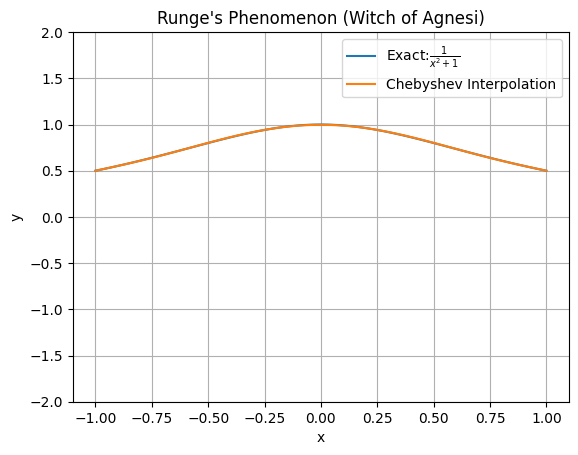

In [115]:
# Code explanation for question 2:

# Plot using Chebyshev nodes.
cheby = True
x: NDArray[np.float_] = np.linspace(-1, 1, 100, dtype=np.float_)
plot(plt.axes(), x, cheby)

Explain how this simplified witch function demonstrates Runge's Phenomenon-> what is it and how does it demonstrate it?
-> Runge’s Phenomenon states that polynomial functions cannot always be accurately approximated by adding more terms to their power series. For Agnesi’s Witch function, adding more terms creates wild oscillations towards the edges of the domain as highlighted in the graph of cell 1. Ultimately, this is due to the exact function’s discontinuities at +/- i and the uniform spacing between the nodes from the nodal polynomial. At the endpoints, the nodes need to be more densely packed together in order to combat the effects of the discontinuities on the polynomial interpolation. To achieve this, we can use Chebyshev nodes as shown above.
-> Answer was aided by: https://en.wikipedia.org/wiki/Runge%27s_phenomenon and https://www.youtube.com/watch?v=F_43oTnTXiw
